In [1]:
# Preamble
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("notebook")

# Almost-scaled multi-head attention

The transformer model architecture is ubiquitous, but we don't fully understand how it works, or what makes it so effective.

At the heart of the transformer is scaled multi-head attention.

While working on [Unit Scaling](https://arxiv.org/abs/2303.11257), Charlie & I noticed something interesting.

Many deep learning modules (functions with attached parameters) are designed and initialised to roughly preserve variance in the forward and/or backward (gradient) passes.

Multi-head self-attention explicitly includes a scaling factor for this: $\sqrt{1/d_h}$ if you're already familiar, but we'll explain this as we go.

But this isn't enough to get multi-head self attention to preserve variance.

Let's see what is.

---

## 1. Following the scale

Here's an equation for non-causal scaled dot product attention (the core, excluding input and output projections):

$A^{\prime} = Q K^T \cdot d_h^{-1/2}$

$O = \mathrm{Softmax}(A^{\prime})\, V$

Here $Q$, $K$ and $V$ are all projections of the input and $d_h$ is the "head dimension". We use $A^{\prime}$ for the pre-softmax attention scores matrix.

Let's see how well it preserves standard deviation, which we'll refer to as _scale_.

In [2]:
sequence_length = 256  # d_s
head_size = 64         # d_h
n_heads = 2
batch_size = 512

q, k, v = torch.randn(3, batch_size, n_heads, sequence_length, head_size)

pre_a = q @ k.transpose(2, 3) * (head_size ** -0.5)  # 1. Scaled QK matmul
a = torch.softmax(pre_a, dim=-1)                     # 2. Softmax
out = a @ v                                          # 3. AV matmul

for name in ["q", "k", "v", "", "pre_a", "a", "out"]:
    if not name: print(); continue
    var = globals()[name]
    print(f"{name:>8}:  μ={var.mean():>6.3f}, σ={var.std():.3f}")

       q:  μ=-0.000, σ=1.000
       k:  μ= 0.000, σ=1.000
       v:  μ=-0.000, σ=1.000

   pre_a:  μ= 0.000, σ=1.001
       a:  μ= 0.004, σ=0.005
     out:  μ=-0.000, σ=0.102


This code generates unit-normal inputs $Q, K, V$ to attention, then prints the mean and scale of intermediate and output tensors $A^{\prime}, A=\mathrm{Softmax}(A^{prime}), O$.

**Step 1 is to compute $Q K^T \cdot d_h^{-1/2}$.**

Here, the scaling factor $d_h^{-1/2}$ is carefully chosen to cancel out the increased scale from the sum of uncorrelated values.

Since $\mathbb{E}(Q \odot K) = 0$ and $\mathbb{E}((Q \odot K)^2) = 1$, the central limit theorem gives $\mathbb{E}((Q K^T)^2) = d_h$.

Therefore to keep unit scale, we must multiply by $d_h^{-1/2}$.

This ensures that $A^{\prime}$, `pre_a` above, is approximately unit scale.

**Step 2 is softmax over the sequence length.**

Note that the softmax itself cannot preserve unit scale, since the outputs are in the range $[0, 1]$; the highest possible scale would be 1/2.

It also cannot ensure zero mean, since it sums to 1 over the target sequence dimension $d_s$, so $\mathbb{E}(A) = d_s^{-1}$.

**Step 3 is to use the attention matrix $A$ to mix the values $V$.**

Following the method of step 1, _if_ the inputs were both zero-mean, unit-scale, we would expect to multiply by $d_s^{-1/2}$ to retain unit scale.

However, as we saw in step 2, the $A$ matrix is far from satisfying this assumption.

In the example above, this means $O$, `out` has a low scale ~1/10, so multiplying by $d_s^{-1/2}$ would move it in entirely the wrong direction!

---

## 2. Explaining the scale

In this section, we'll try to explain why $O$ is under-scaled in standard attention.

We'll first introduce a temperature $t$ into the softmax, as it gives two extreme cases that are a bit simpler to follow, before tackling the more difficult $t=1$ case.

For $x \in \mathcal{R}^{d_s}$, define $\mathrm{Softmax}(x, t)_i = e^{x_i / t} \,/ \sum_j{e^{x_j/t}}$.

**2.1 In the extreme $t\to\infty$**, we get $\mathrm{Softmax}(x, t)_i = d_s^{-1}$, which is a flat distribution over attention keys.

Plugging this into attention above, we'd expect $\mathbb{E}((A \odot V)^2) = d_s^{-2}$, so $\mathbb{E}((A V)^2) = d_s^{-1}$.

Overall, then, we'd expect $t\to\infty$ attention to have output scale $d_s^{-1/2}$, i.e.

In [3]:
sequence_length ** -0.5

0.0625

This isn't very far from the 1/10 observed above.

**2.2 In the extreme $t\to 0$**, we get $\mathrm{Softmax}(x, t)_i = \mathbb{I}(x_i\!==\!\mathrm{Max}(x))$, which is a unit "spike" on the maximum value of $x$.

In attention, since $A$ and $V$ are uncorrelated, the matrix multiplication $A V$ then selects a random value from $V$, therefore $\mathbb{E}((A V)^2) = 1$.

Therefore, we'd expect $t\to 0$ attention to have output scale $1$, which is quite far from 1/10.

**2.3 Otherwise**, we will need some further analysis.

We start by assuming that the values going into the softmax are normally distributed, with scale $1/t$.

Then, we rewrite softmax as $\mathrm{Softmax}(x)_i = e^{x_i - \log\sum_j{e^{x_j}}}$.

Now we treat the log-sum-exp term as a constant, and will later ensure that the softmax is _normalised in expectation_, so we can say:

$A = e^{A^{\prime}},\; A^{\prime} \sim N(\mu, t^{-2})$

$A$ therefore follows a LogNormal distribution, Given the normalisation-in-expectation constraint $\mathbb{E}(A)=d_s^{-1}$, we can solve for the unknown $\mu$, giving:

$A \sim \mathrm{LogNormal}(-\ln(d_s) - \frac{1}{2}\, t^{-2}, t^{-2})$.

Since we assume $A$ and $V$ are independent, $\mathbb{E}(A \odot V) = \mathbb{E}(A)\, \mathbb{E}(V) = 0$.

Also, $\mathbb{E}((A \odot V)^2) = \mathbb{E}(A^2)\, \mathbb{E}(V^2) = e^{2\mu + 2\sigma^2} = d_s^{-2}\,e^{t^{-2}}$, so $\mathbb{E}((A V)^2) = d_s^{-1}\,e^{t^{-2}}$.

**Quick check**

Now let's see if these rules work, for $\mathrm{Softmax}(A^{\prime} V)$, in isolation:

In [7]:
def softmax_std_scaling(sequence_length: int, temperature: float, nelement: int = int(1e7)) -> float:
    pre_a = torch.randn(nelement // sequence_length, sequence_length)
    v = torch.randn(nelement // sequence_length, sequence_length)
    out = (torch.softmax(pre_a / temperature, -1) * v).sum(-1)
    return out.std()

def lognormal_softmax_std_scaling(sequence_length: int, temperature: float) -> float:
    return torch.minimum(torch.tensor(1), sequence_length ** -0.5 * torch.exp(temperature ** -2 / 2))

Hopefully no surprises in the implementation of the above. Let's see how it works as we vary temperature:

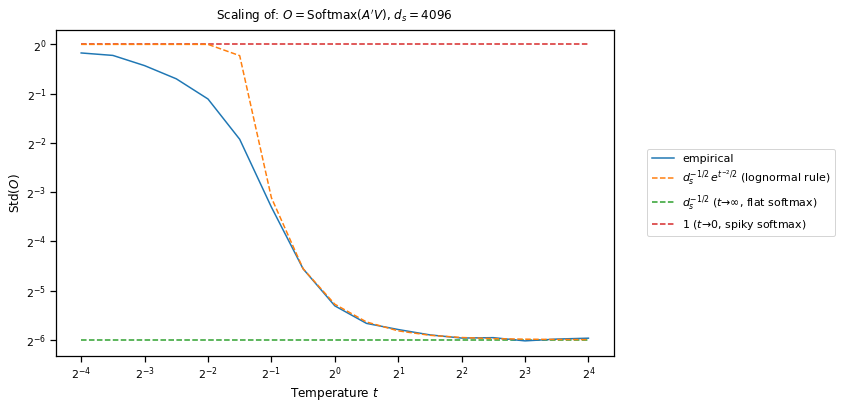

In [8]:
temperatures = 2 ** torch.arange(-4, 4.01, 0.5)
sequence_length = 4096
empirical_scaling = [softmax_std_scaling(sequence_length=sequence_length, temperature=t) for t in temperatures]
lognormal_scaling = lognormal_softmax_std_scaling(sequence_length=sequence_length, temperature=temperatures)
temperature_inf_scaling = sequence_length ** -0.5
temperature_zero_scaling = 1.0

plt.figure(figsize=(10, 6)) ; c = iter(sns.color_palette())
plt.plot(temperatures, empirical_scaling, color=next(c), label="empirical")
plt.plot(temperatures, lognormal_scaling, color=next(c),
         linestyle="dashed", label="$d_s^{-1/2}\, e^{t^{-2} / 2}$ (lognormal rule)")
plt.hlines(temperature_inf_scaling, temperatures.min(), temperatures.max(),
           color=next(c), linestyle="dashed", label=r"$d_s^{-1/2}$ ($t\to\infty$, flat softmax)")
plt.hlines(temperature_zero_scaling, temperatures.min(), temperatures.max(),
           color=next(c), linestyle="dashed", label=r"$1$ ($t\to 0$, spiky softmax)")
plt.xscale("log", base=2) ; plt.yscale("log", base=2)
plt.xlabel("Temperature $t$") ; plt.ylabel(r"$\mathrm{Std}(O)$")
plt.xticks(2**torch.arange(-4, 4.01)) ; plt.legend(loc="center left", bbox_to_anchor=(1.05, 0.5))
plt.title(f"Scaling of: $O = \mathrm{{Softmax}}(A^{{\prime}} V)$, $d_s={sequence_length}$", pad=10);

That's not too bad. Our $t\to\infty$ and $t\to 0$ rules give the right asymptotes, and the lognormal rule seems to work OK for $t>\frac{1}{2}$.

We expect the lognormal breakdown is due to the fact that our model only normalises the softmax in expectation, whereas the true softmax will normalise over a finite set of samples.

So, now we should be fully equipped with a model to normalise the forward pass of attention.

---

# 3. Fixing the scale

We saw that the pre-softmax scaling of multi-head attention is working as expected, but that we need to add an additional post-softmax scale factor if we don't want the scale to shrink through attention as a whole.

Without a scale factor, we expect unit-scaled inputs to produce outputs of scale $(e/d_s)^{1/2}$.

To counteract this, we can modify the scaled attention equation thus:

$A^{\prime} = Q K^T \cdot d_h^{-1/2}$

$O = \mathrm{Softmax}(A^{\prime})\, V \color{red}{\cdot (d_s/e)^{1/2}}$

Let's implement & sanity-check:

In [16]:
sequence_length = 256  # d_s
head_size = 64         # d_h
n_heads = 2
batch_size = 512

q, k, v = torch.randn(3, batch_size, n_heads, sequence_length, head_size)

pre_a = q @ k.transpose(2, 3) * (head_size ** -0.5)  # 1. Scaled QK matmul
a = torch.softmax(pre_a, dim=-1)                     # 2. Softmax
out = a @ v * (sequence_length / np.e) ** 0.5        # 3. Scaled AV matmul

for name in ["q", "k", "v", "", "pre_a", "a", "out"]:
    if not name: print(); continue
    var = globals()[name]
    print(f"{name:>8}:  μ={var.mean():>6.3f}, σ={var.std():.3f}")

       q:  μ= 0.001, σ=1.000
       k:  μ= 0.000, σ=1.000
       v:  μ=-0.000, σ=1.000

   pre_a:  μ= 0.000, σ=1.000
       a:  μ= 0.004, σ=0.005
     out:  μ=-0.001, σ=0.992


That's grand—as we hoped, our `out` is now roughly unit-scale, so we've found a well-scaled attention "core".

Note that causal masking and (possibly) positional encodings may cause additional scaling, but we leave these as an exercise for the reader.

> (Aside) this takes us part of the way to _unit scaling_, which isn't just concerned with the scale of the forward pass. It would have us also calculate the backward scaling and compensate accordingly.

---

# 4. Oh no, it doesn't work!

That title gives this next bit away.

So, let's see what happens if we optimistically implement this "improvement" that fixes the scaling of attention, in a full transformer.

To keep things quick and simple, we'll train a small autoregressive byte-level transformer model on the works of Shakespeare.

We'll use a fixed batch size, number of steps and model size, on the assumption that this scaling change should work over similar ranges as the baseline.

We're also only interested in training dynamics, not whether this change has an impact on generalisation, so our test metric will be final training loss.

However, since we have changed the scaling applied to a subset of the model, we will re-sweep learning rate, as the best learning rate may have changed.

With all that, let's see how it performs (note that the code is tucked away inside the companion module `demo_transformer`, feel free to take a look though, it won't bite!)

100%|██████████| 500/500 [00:18<00:00, 27.54it/s]


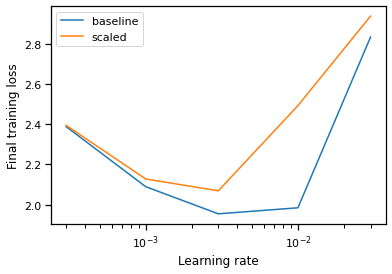

In [18]:
# !wget https://www.gutenberg.org/cache/epub/100/pg100.txt -O shakespare.txt
import demo_transformer

def sweep_lr():
    for lr in [3e-4, 1e-3, 3e-3, 1e-2, 3e-2]:
        demo_transformer.CONFIG.lr = lr
        log = demo_transformer.train()
        yield dict(lr=lr, loss=float(log[-20:].mean()))

demo_transformer.CONFIG.fully_scaled_attention = False
baseline_results = list(sweep_lr())
demo_transformer.CONFIG.fully_scaled_attention = True
scaled_results = list(sweep_lr())

for name, data in dict(baseline=baseline_results, scaled=scaled_results).items():
    plt.plot([d["lr"] for d in data], [d["loss"] for d in data], label=name)
plt.xscale("log") ; plt.legend() ; plt.xlabel("Learning rate") ; plt.ylabel("Final training loss");

Oh dear, it's not quite as good as the underscaled baseline.

We haven't been able to fully get to the bottom of this, but it looks like the scale-preserving attention cannot tolerate such a high learning rate as the baseline.

This seems plausible, and would imply that the learning dynamics of the attention parameters are less stable than those of the feed-forward layers.

Altogether, it's curious that a happy conincidence of an under-scaled baseline has this beneficial impact on training.

> Since unit scaling requires that we get rid of these implicit scaling rules, and keep everything well-scaled, it offers another solution to this problem, which is to introduce a residual weight when adding the contribution of the attention module to the skip connection from the previous layer. This can be made to have exactly the same effect as the implicit baseline scaling, while keeping intermediate tensors close to unit scale. (It's also the reason we noticed this interesting property of attention layers in transformer models.)

---

# 5. Conclusion

We started by asking the question "why doesn't self-attention preserve unit scale", which took us on a (hopefully) stimulating journey via the LogNormal distribution to a new scaling law for "fully scaled self-attention".

Here it is, again:

$A^{\prime} = Q K^T \cdot d_h^{-1/2}$

$O = \mathrm{Softmax}(A^{\prime})\, V \color{red}{\cdot (d_s/e)^{1/2}}$

Excitingly, this seemed to do the (scaling) job as we'd hoped.

Less exciting, but equally interesting, this change seemed to hurt the convergence of a full autoregressive transformer model.

More work is needed to understand why, but it seems to be linked to a lower maximum learning rate that can be tolerated when we increase the scale of self-attention.

This indicates that training stability is improved when the weighting of the pointwise FFN layers (in terms of activation std) is larger than that of the attention layers.

We'll leave it there for today; stay cool & well-scaled!